# Analysing and plotting results
These won't make much sense yet, since the model is only trained for few epochs.
Later when the whole pipeline is finished and working, I'll concentrate on improving the the results

In [34]:
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score
from keras.preprocessing.image import ImageDataGenerator
from pickle import load
from matplotlib.pylab import plt
from numpy import arange

In [35]:
def load_data(processed_X_test_path: str):
    X_test = pd.read_csv(processed_X_test_path)
    X_test['filepath'] = X_test['filepath'].apply(lambda x: '../' + x)

    return X_test


def load_model(model_filepath: str):
    return tf.keras.saving.load_model(model_filepath)

In [36]:
test_df = load_data('../data/processed/X_test.csv')
model = load_model('../models/cat_classifier.keras')

In [37]:
test_df.drop(columns=test_df.columns[0], inplace=True)
test_df.head()

,filepath,label
0,../data/images/Balinese/43064974_101.jpg,Balinese
1,../data/images/Balinese/39481692_184.jpg,Balinese
2,../data/images/Tonkinese/13206432_829.jpg,Tonkinese
3,../data/images/Balinese/37652078_226.jpg,Balinese
4,../data/images/Balinese/26606189_581.jpg,Balinese


In [38]:
img_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=30, 
                                   width_shift_range=0.2,
                                   height_shift_range=0.2, 
                                   horizontal_flip = 'true')

X_test = img_datagen.flow_from_dataframe(dataframe = test_df,  x_col='filepath', y_col='label',  target_size=(299, 299), shuffle=False, batch_size=30, seed = 12)

Found 102 validated image filenames belonging to 3 classes.


In [39]:
predictions = model.predict(X_test)
predictions = np.argmax(predictions, axis=1)
predictions

2023-10-15 23:33:24.029534: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-15 23:33:24.861796: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


4/4 [==============================] - 8s 608ms/step


array([1, 1, 2, 1, 0, 0, 1, 1, 0, 2, 1, 1, 2, 0, 0, 2, 2, 0, 0, 1, 2, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 2, 1, 0, 1, 1, 1, 2, 0,
       2, 1, 2, 0, 2, 0, 1, 0, 1, 2, 0, 1, 0, 1, 1, 0, 1, 0, 0, 2, 0, 2,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 2, 0, 0, 0, 1, 1, 2, 2, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 2, 0, 1, 2, 2, 1, 1])

In [40]:
# Figure out how to load from hydra configurations
indices = {
    'Abyssinian': 0,
    'Balinese': 1,
    'Tonkinese': 2
}

test_df["label"].replace(indices, inplace=True)

In [41]:
test_df.head()

,filepath,label
0,../data/images/Balinese/43064974_101.jpg,1
1,../data/images/Balinese/39481692_184.jpg,1
2,../data/images/Tonkinese/13206432_829.jpg,2
3,../data/images/Balinese/37652078_226.jpg,1
4,../data/images/Balinese/26606189_581.jpg,1


In [42]:
test_accuracy = model.evaluate(X_test)[1] * 100
print('Test accuracy is : ',test_accuracy, '%' )

4/4 [==============================] - 4s 367ms/step - loss: 0.5862 - accuracy: 0.7451
Test accuracy is :  74.50980544090271 %


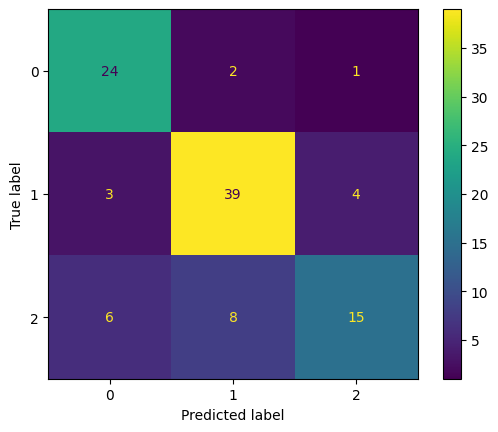

In [43]:
# Not that great as expected, since model was trained only for one epoch anyways
cf = confusion_matrix(test_df["label"] , predictions)
disp = ConfusionMatrixDisplay(cf)
disp.plot()

In [44]:
print(classification_report(test_df["label"], predictions))

              precision    recall  f1-score   support

           0       0.73      0.89      0.80        27
           1       0.80      0.85      0.82        46
           2       0.75      0.52      0.61        29

    accuracy                           0.76       102
   macro avg       0.76      0.75      0.74       102
weighted avg       0.76      0.76      0.76       102



In [45]:
print("F1 score: ", f1_score(test_df['label'], predictions, average = 'weighted'))

F1 score:  0.7561129715043912


In [46]:
history = load(open('../data/processed/tf_history.pkl', 'rb'))

In [47]:
def plot(history, train_key, val_key, title, ylabel):
    train_data = history.history[train_key]
    val_data = history.history[val_key]
    n_epochs = len(history.epoch)
    
    epochs = range(n_epochs)
    
    plt.plot(epochs, train_data, label='Training Loss')
    plt.plot(epochs, val_data, label='Validation Loss')
    
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)

    plt.xticks(arange(0, n_epochs, 2))
    
    plt.legend(loc='best')
    plt.show()

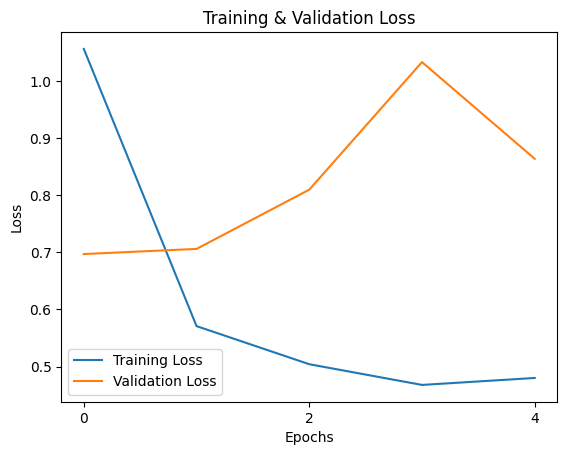

In [48]:
# Plot loss
plot(history, 'loss', 'val_loss', 'Training & Validation Loss', 'Loss')

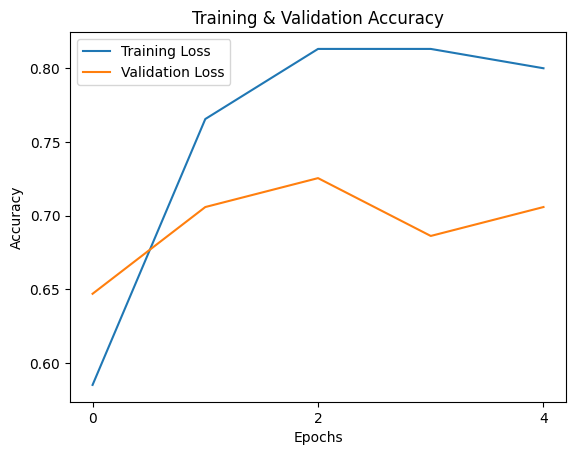

In [49]:
# Plot Accuracy
plot(history, 'accuracy', 'val_accuracy', 'Training & Validation Accuracy', 'Accuracy')